# CamVid (Cambridge-Driving Labeled Video Database)

## Description
The Cambridge-driving Labeled Video Database (CamVid) provides ground truth labels that associate each pixel with one of 32 semantic classes. This dataset is often used in (real-time) semantic segmentation research.

The dataset is split up as follows:

* 367 training pairs
* 101 validation pairs
* 233 test pairs

The images and masks for each split are in a separate directory.

Citations:

[1] Brostow, Shotton, Fauqueur, Cipolla. **Segmentation and Recognition Using Structure from Motion Point Clouds**, 
_European Conference on Computer Vision (ECCV)_, 2008.

[2] Brostow, Fauqueur, Cipolla. **Semantic Object Classes in Video: A High-Definition Ground Truth Database**, 
_Pattern Recognition Letters_.

The original dataset can be found here:
http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid

Source / Contact:
http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid

Kaggle Source:
https://www.kaggle.com/datasets/carlolepelaars/camvid

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import tarfile 
import pandas as pd
import os
import numpy as np
import seaborn as sns
import gc

from tensorflow.keras import backend as K
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [3]:
# Initialize notebook constants/config class
class CFG():
    RANDOM_SEED=42
    IMG_HEIGHT=480
    IMG_WIDTH=640
    BATCH_SIZE=4

In [4]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
    try:
        for gpu in physical_devices:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [5]:
files_path = "../input/camvid/CamVid/"

In [6]:
unique_classes = pd.read_csv(files_path + "class_dict.csv")
unique_classes.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


In [7]:
color_map = unique_classes.drop("name", axis=1)
color_map_tf = tf.constant(color_map, dtype=tf.int32)

In [8]:
train_files = tf.data.Dataset.list_files(files_path + "train/*.png") 
val_files = tf.data.Dataset.list_files(files_path + "val/*.png") 
test_files = tf.data.Dataset.list_files(files_path + "test/*.png")

In [9]:
def rgb_class_convert(label_rgb, color_map, inverse=False):

    if not inverse:
        label_expanded = tf.expand_dims(label_rgb, axis=-2)  # [H, W, 1, 3]
        color_map_expanded = tf.reshape(color_map, [1, 1, -1, 3])  # [1, 1, N, 3]
        matches = tf.reduce_all(tf.equal(label_expanded, color_map_expanded), axis=-1)  # [H, W, num_classes]
        class_indices = tf.argmax(tf.cast(matches, tf.int32), axis=-1)
    else:
        #label_indices = tf.argmax(label_rgb, axis=-1)
        label_indices = tf.cast(label_rgb, tf.int16)
        rgb_image = tf.gather(color_map, label_indices)
        class_indices = rgb_image

    return class_indices

In [10]:
@tf.function
def load_image(img_path: tf.Tensor):
    image_bytes = tf.io.read_file(img_path)
    image = tf.image.decode_png(image_bytes, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (CFG.IMG_HEIGHT, CFG.IMG_WIDTH))
    
    label_path_base = tf.strings.regex_replace(img_path, "train/", "train_labels/")
    label_path_base = tf.strings.regex_replace(label_path_base, "val/", "val_labels/")
    label_path_base = tf.strings.regex_replace(label_path_base, "test/", "test_labels/")
    label_path =  tf.strings.regex_replace(label_path_base, ".png", "_L.png")
        
    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=3)
    label = tf.image.resize(label, (CFG.IMG_HEIGHT, CFG.IMG_WIDTH), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.cast(label, tf.int32)
    label = rgb_class_convert(label, color_map_tf)
    #label = tf.one_hot(label, depth=len(unique_classes))
    label = tf.expand_dims(label, axis=-1)
    label = tf.cast(label, tf.float32)
    
    return image, label

In [11]:
def configure_performance(ds, is_train_ds: bool):
    ds = ds.cache()

    if is_train_ds:
        ds = ds.shuffle(buffer_size=50)
    
    ds = ds.batch(CFG.BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

In [26]:
def display_imgs(display_list, unique_classes, show_classes=True):
    
    display_list = list(display_list)
    display_list.insert(1, tf.squeeze(rgb_class_convert(display_list[1], color_map_tf, inverse=True))) # Inverse Transformed to color scale
    if len(display_list) > 3:
        display_list[-1] = tf.expand_dims(tf.argmax(display_list[-1], axis=-1), axis=-1)

    num_images = len(display_list)
    fig, axes = plt.subplots(1, num_images, figsize=(14, 10))
    
    titles = ['Input Image', 'True Mask', 'Class-indexed Mask', 'Predicted Mask']
    
    for ax, image, title in zip(axes, display_list, titles):
        ax.set_title(title)
        ax.imshow(tf.keras.utils.array_to_img(image))
        ax.axis('off')

    if show_classes:
        mask_tensor = display_list[2]
        mask_np = mask_tensor.numpy()
        unique_ids = np.unique(mask_np)
        unique_classes_filtered = unique_classes.iloc[unique_ids]
        
        handles = []
        for _, row in unique_classes_filtered.iterrows():
            label = f"{row['name']}"
            color_float = (row['r'] / 255.0, row['g'] / 255.0, row['b'] / 255.0)
            patch = mpatches.Patch(color=color_float, label=label)
            handles.append(patch)
        
        max_cols = 5
        ncols = min(len(handles), max_cols)   
        fig.legend(handles=handles,
                   title="True Mask Classes Colors (only)",
                   loc='lower center',
                   bbox_to_anchor=(0.5, 0.2),
                   ncol=ncols,
                   borderaxespad=0.)
        
    plt.show()

In [13]:
train_ds = train_files.map(lambda img_path: load_image(img_path), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_ds = val_files.map(lambda img_path: load_image(img_path), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [14]:
sample_img, sample_label = next(iter(train_ds))

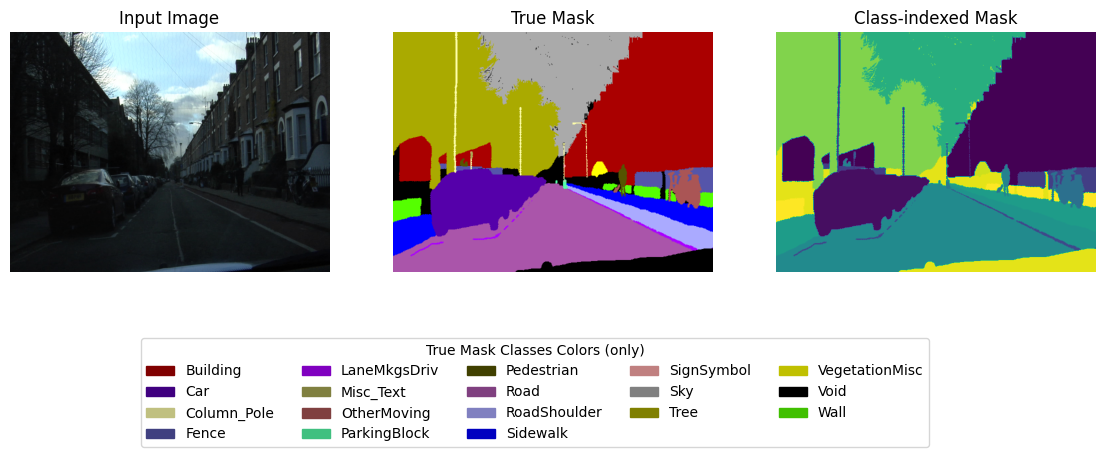

In [15]:
display_imgs([sample_img, sample_label], unique_classes)

In [16]:
train_ds = configure_performance(train_ds, is_train_ds=True)
val_ds = configure_performance(val_ds, is_train_ds=False)

# Define U-Net with MobileNetV2 Pretrained Model

In [17]:
# References for Conv2DTranspose and MobileNetV2 model
# (1): https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2
# (2): https://www.tensorflow.org/tutorials/images/segmentation
# (3): https://keras.io/api/applications/mobilenet/

def unet_mobilenetv2(input_shape=(480, 640, 3), num_classes=None):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights='imagenet'
    )
    
    layer_names = [
        'block_1_expand_relu',  
        'block_3_expand_relu',   
        'block_6_expand_relu',   
        'block_13_expand_relu',  
        'block_16_project'    
    ]
    
    layers_outputs = [base_model.get_layer(name).output for name in layer_names]
    
    encoder = tf.keras.Model(inputs=base_model.input, outputs=layers_outputs)
    encoder.trainable = False
    
    def decoder_block(inputs, skip, filters):
        x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=3, strides=2, 
                                            padding='same', activation='relu')(inputs)
        x = tf.keras.layers.Concatenate()([x, skip])
        x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding='same', activation='relu')(x)
        return x

    inputs = tf.keras.Input(shape=input_shape)
    skips = encoder(inputs)
    x = skips[-1]
    
    x = decoder_block(x, skips[3], 512)  
    x = decoder_block(x, skips[2], 256) 
    x = decoder_block(x, skips[1], 128)  
    x = decoder_block(x, skips[0], 64)   # Upsample from (120,160) to (240,320) and merge with block_1_expand_relu.
    
    x = tf.keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)  # from (240,320) to (480,640)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    
    outputs = tf.keras.layers.Conv2D(num_classes, kernel_size=1, activation='softmax')(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [18]:
# Build and display the model summary.
model = unet_mobilenetv2(input_shape=(CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3), num_classes=len(unique_classes))
model.summary()

<ipython-input-17-6546cb346578>:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 480, 640, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional (Functional)   │ [(None, 240, 320, 96), │      1,841,984 │ input_layer_1[0][0]    │
│                           │ (None, 120, 160, 144), │                │                        │
│                           │ (None, 60, 80, 192),   │                │                        │
│                           │ (None, 30, 40, 576),   │                │                        │
│                           │ (None, 15, 20, 320)]   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 30, 40, 512)    │      1,475,072 │ functional[0][4]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 30, 40, 1088)   │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ functional[0][3]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 30, 40, 512)    │      5,014,016 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 30, 40, 512)    │      2,359,808 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 60, 80, 256)    │      1,179,904 │ conv2d_1[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 80, 448)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ functional[0][2]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 60, 80, 256)    │      1,032,448 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 60, 80, 256)    │        590,080 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 120, 160, 128)  │        295,040 │ conv2d_3[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 120, 160, 272)  │              0 │ conv2d_transpose_2[0]… │
│ (Concatenate)             │                        │                │ functional[0][1]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 120, 160, 128)  │        313,472 │ concatenate_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 120, 160, 128)  │        147,584 │ conv2d_4[0][0]         │
├──────────────────────

 Total params: 14,490,368 (55.28 MB)

 Trainable params: 12,648,384 (48.25 MB)

 Non-trainable params: 1,841,984 (7.03 MB)

In [19]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1,2])
    union = tf.reduce_sum(y_true, axis=[1,2]) + tf.reduce_sum(y_pred, axis=[1,2])
    dice = (2 * intersection + smooth) / (union + smooth) # multiply by two because of union divider
    
    return 1 - tf.reduce_mean(dice) 

In [20]:
def total_loss(y_true, y_pred):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return ce + dice

In [21]:
EPOCHS = 15

##approx calculation
train_steps= int((len(train_files) / CFG.BATCH_SIZE) * EPOCHS)
warmup_steps=int(train_steps * 0.1)
decay_steps=train_steps - warmup_steps

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    alpha=0.0
)

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=total_loss,
    metrics=['accuracy']
)

In [23]:
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
)

Epoch 1/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 125s 859ms/step - accuracy: 0.1900 - loss: 3.7800 - val_accuracy: 0.6112 - val_loss: 2.4844
Epoch 2/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.6181 - loss: 2.3791 - val_accuracy: 0.7430 - val_loss: 1.9348
Epoch 3/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.7602 - loss: 1.8644 - val_accuracy: 0.7934 - val_loss: 1.7561
Epoch 4/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8047 - loss: 1.6738 - val_accuracy: 0.8195 - val_loss: 1.6589
Epoch 5/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8198 - loss: 1.6060 - val_accuracy: 0.8294 - val_loss: 1.5922
Epoch 6/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8297 - loss: 1.5534 - val_accuracy: 0.8260 - val_loss: 1.6096
Epoch 7/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 199ms/step - accuracy: 0.8382 - loss: 1.5119 - val_accuracy: 0.8378 - val_loss: 1.5372
Epoch 8/15
93/93 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8507 - loss: 1.4588 - val_acc

In [24]:
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - accuracy: 0.8695 - loss: 1.4504
Validation Loss: 1.4348841905593872
Validation Accuracy: 0.8722784519195557


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


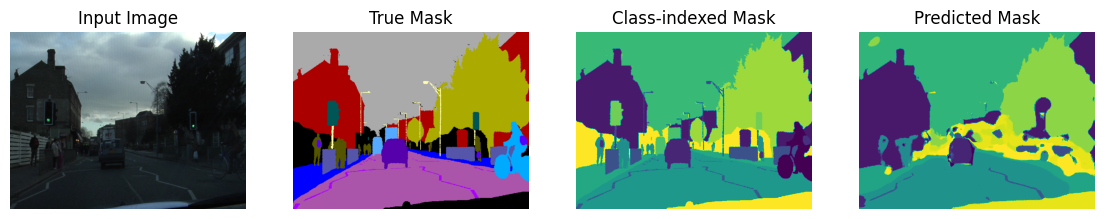

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


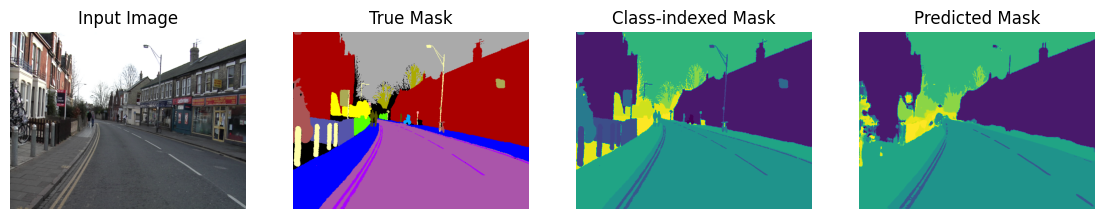

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


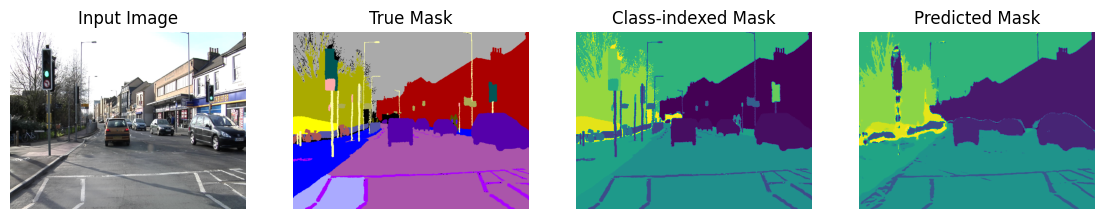

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


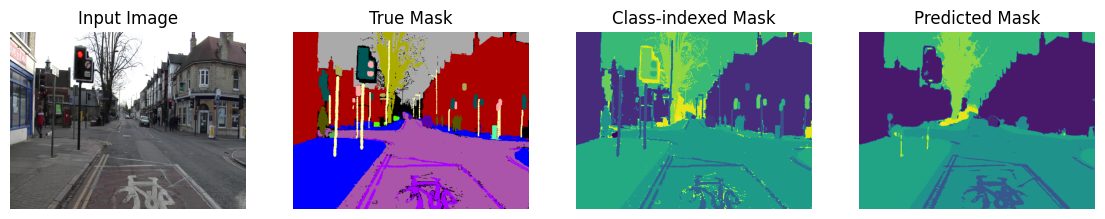

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


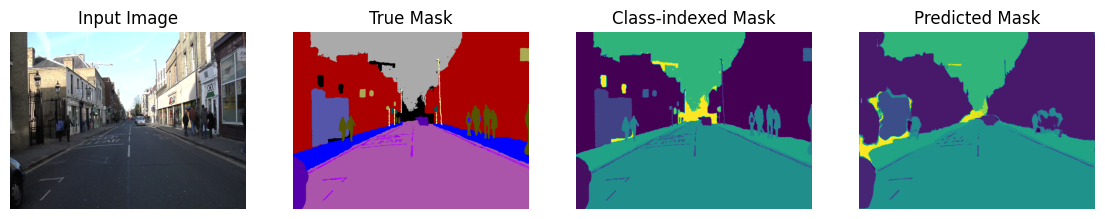

In [27]:
for samples in val_ds.take(5):
    sample_img = (samples[0][0], samples[1][0], model.predict(samples[0])[0])
    display_imgs(sample_img, unique_classes, show_classes=False)

In [29]:
labels_list = []

for x_batch, y_batch in val_ds:    
    labels_list.append(y_batch.numpy())

labels = np.concatenate(labels_list, axis=0)

In [43]:
predictions = model.predict(val_ds)
pred_class = tf.argmax(predictions, axis=-1) 
true_class = tf.squeeze(labels, axis=-1)

pred_class = pred_class.numpy()
true_class = true_class.numpy()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


In [44]:
num_classes = len(unique_classes)
pred_class_flat = pred_class.reshape(-1)
true_class_flat = true_class.reshape(-1)

conf_mat_tf = tf.math.confusion_matrix(true_class_flat, pred_class_flat, num_classes=num_classes)
conf_mat_norm =  conf_mat_tf / tf.reduce_sum(conf_mat_tf, axis=1, keepdims=True)
conf_mat = conf_mat_tf.numpy()

In [45]:
sum_over_rows = np.sum(conf_mat, axis=0)
sum_over_cols = np.sum(conf_mat, axis=1)
diag = np.diag(conf_mat)
denominator = sum_over_rows + sum_over_cols - diag
iou_per_class = diag / (denominator + 1e-7)
mean_iou = np.mean(iou_per_class)

pixel_accuracy = np.sum(diag) / np.sum(conf_mat)

print("IoU per class:", iou_per_class)
print("Mean IoU:", mean_iou)
print("Pixel-wise Accuracy:", pixel_accuracy)

IoU per class: [0.00000000e+00 0.00000000e+00 3.80016697e-01 0.00000000e+00
 8.32201066e-01 7.45650844e-01 0.00000000e+00 0.00000000e+00
 2.61415870e-02 5.08812259e-01 5.39014027e-01 0.00000000e+00
 2.54245081e-04 0.00000000e+00 2.15385863e-02 2.52946630e-03
 2.43120302e-01 9.24543295e-01 4.16108782e-03 8.02707442e-01
 0.00000000e+00 9.20801292e-01 1.11783194e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 7.82258610e-01 0.00000000e+00
 0.00000000e+00 4.72985622e-01 1.71037744e-01 3.97332846e-01]
Mean IoU: 0.24646531911195504
Pixel-wise Accuracy: 0.8722779947916667


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


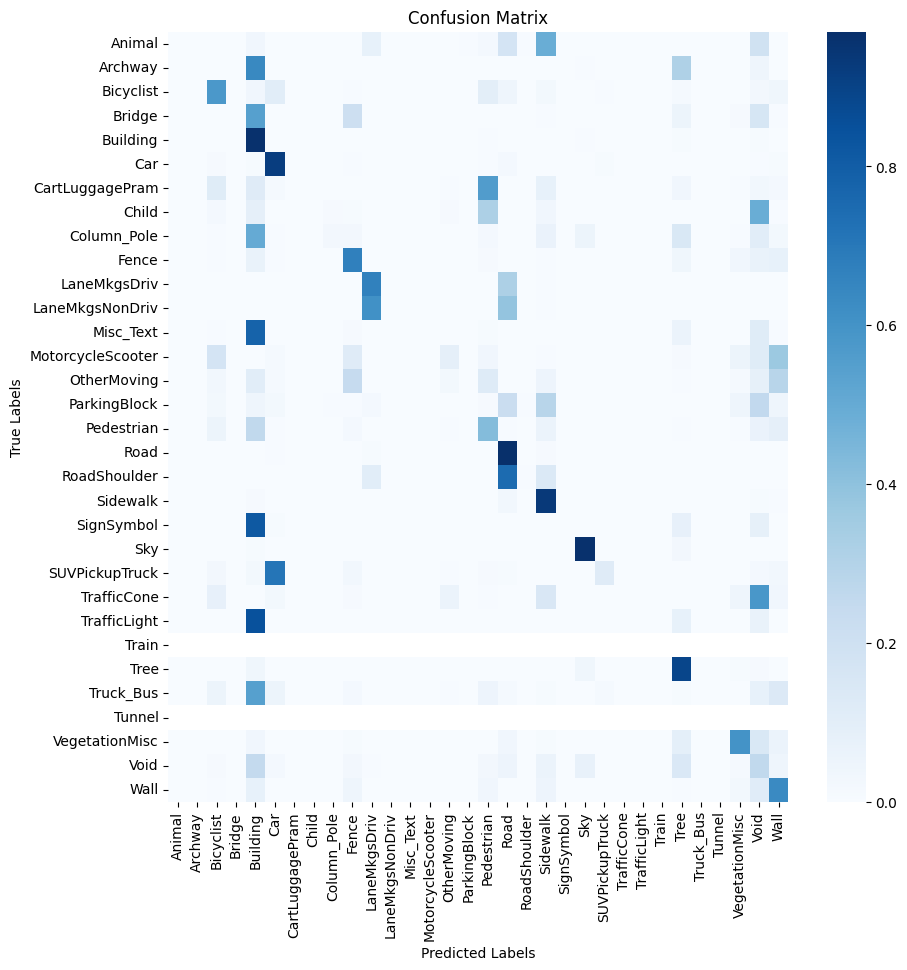

In [46]:
class_names = unique_classes.name.to_list()

plt.figure(figsize=(10, 10))
sns.heatmap(
    conf_mat_norm, 
    annot=False, 
    fmt='.4f', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names,
)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Predict on test set

In [47]:
all_train_files_ds = train_files.concatenate(val_files)

In [48]:
train_ds = all_train_files_ds.map(lambda img_path: load_image(img_path), num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_files.map(lambda img_path: load_image(img_path), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [49]:
sample_img, sample_label = next(iter(test_ds))

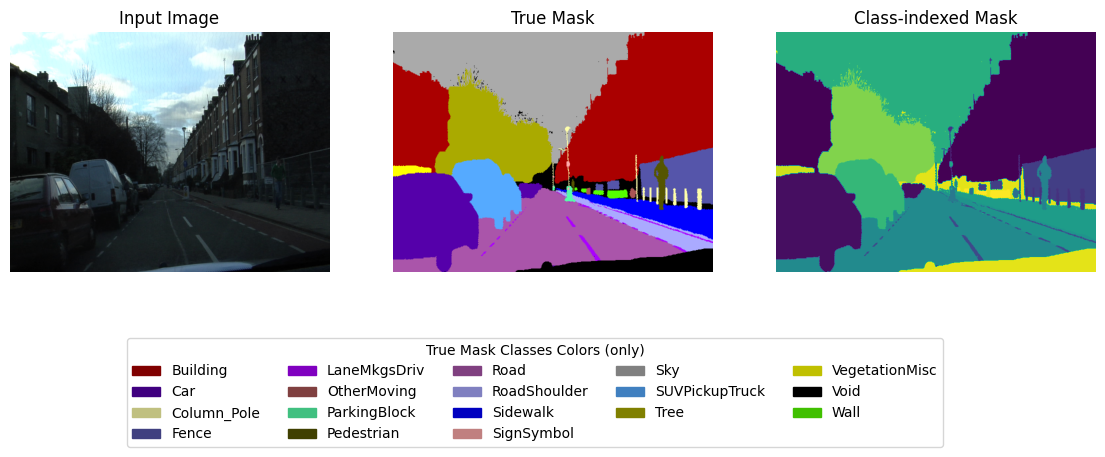

In [50]:
display_imgs([sample_img, sample_label], unique_classes)

In [51]:
train_ds = configure_performance(train_ds, is_train_ds=True)
test_ds = configure_performance(test_ds, is_train_ds=False)

In [52]:
EPOCHS = 15

##approx calculation
train_steps= int((len(all_train_files_ds) / CFG.BATCH_SIZE) * EPOCHS)
warmup_steps=int(train_steps * 0.1)
decay_steps=train_steps - warmup_steps

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5,
    warmup_target=0.001,
    warmup_steps=warmup_steps,
    decay_steps=decay_steps,
    alpha=0.0
)

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr_schedule),
    loss=total_loss,
    metrics=['accuracy']
)

In [54]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=EPOCHS,
)

Epoch 1/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 117s 800ms/step - accuracy: 0.8887 - loss: 1.3166 - val_accuracy: 0.8301 - val_loss: 1.5901
Epoch 2/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 216ms/step - accuracy: 0.8617 - loss: 1.4266 - val_accuracy: 0.8336 - val_loss: 1.5693
Epoch 3/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.8737 - loss: 1.3705 - val_accuracy: 0.8356 - val_loss: 1.5345
Epoch 4/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.8853 - loss: 1.3308 - val_accuracy: 0.8429 - val_loss: 1.5228
Epoch 5/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.8922 - loss: 1.3041 - val_accuracy: 0.8457 - val_loss: 1.5108
Epoch 6/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 26s 218ms/step - accuracy: 0.8971 - loss: 1.2850 - val_accuracy: 0.8503 - val_loss: 1.5132
Epoch 7/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.9005 - loss: 1.2744 - val_accuracy: 0.8559 - val_loss: 1.5001
Epoch 8/15
118/118 ━━━━━━━━━━━━━━━━━━━━ 25s 216ms/step - accuracy: 0.9104 - loss: 

In [56]:
loss, accuracy = model.evaluate(test_ds)
print("Validation Loss:", loss)
print("Test Accuracy:", accuracy)

58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.8675 - loss: 1.5190
Validation Loss: 1.5288493633270264
Test Accuracy: 0.8658649921417236


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


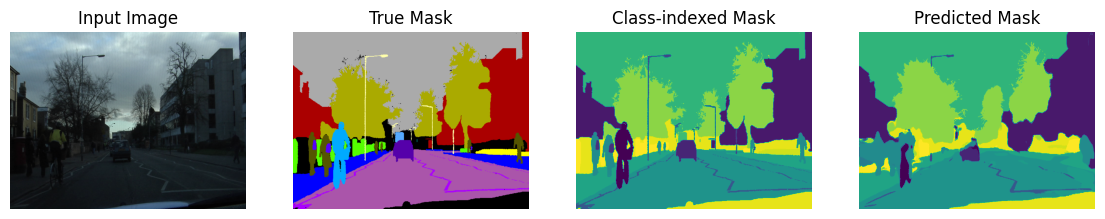

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


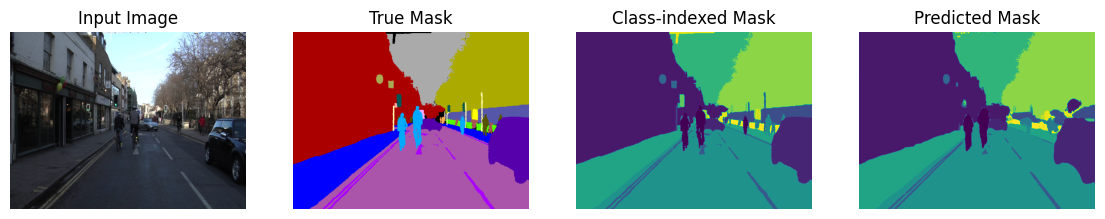

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


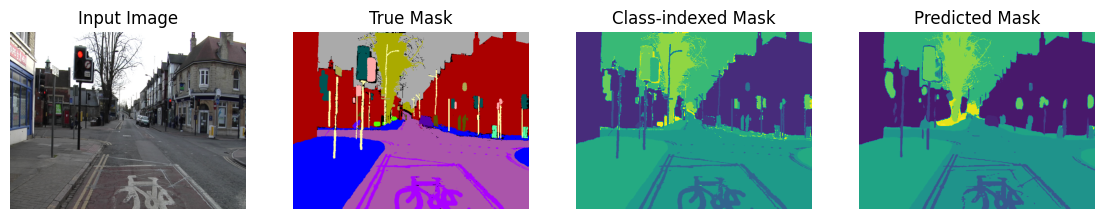

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


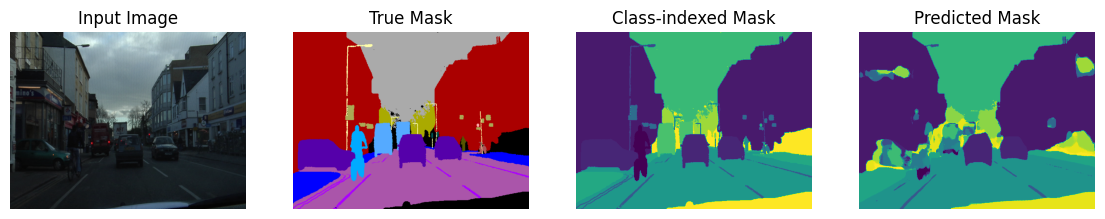

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


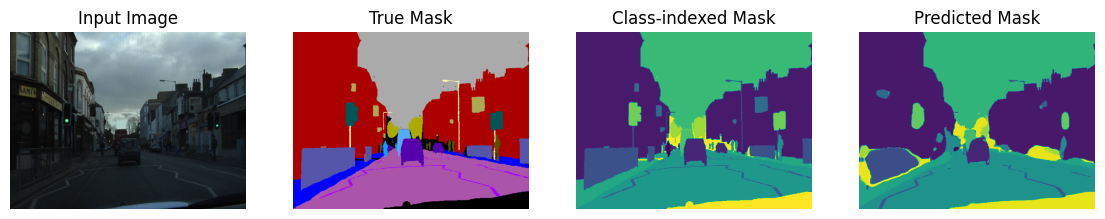

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


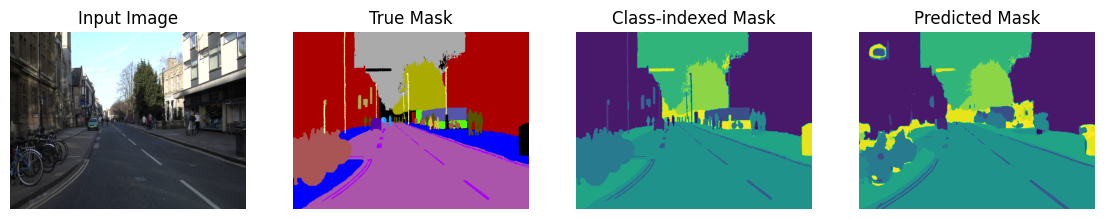

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


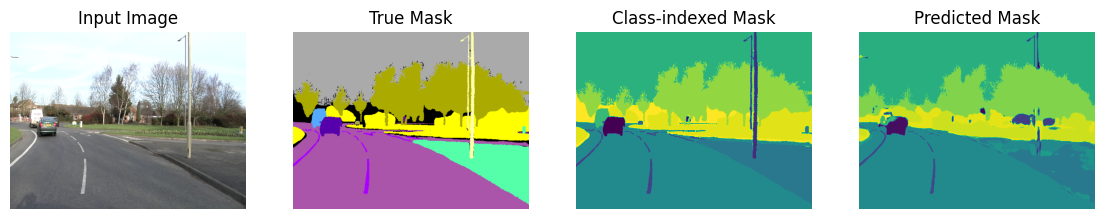

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


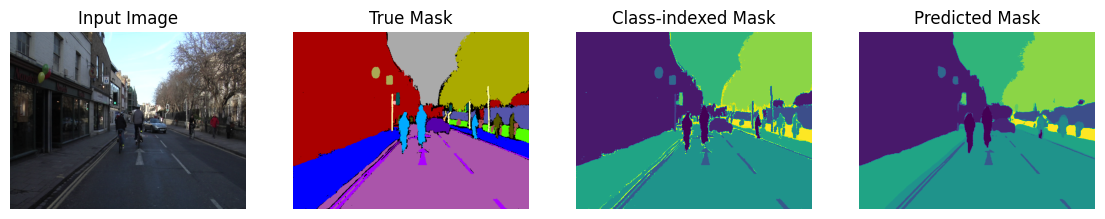

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


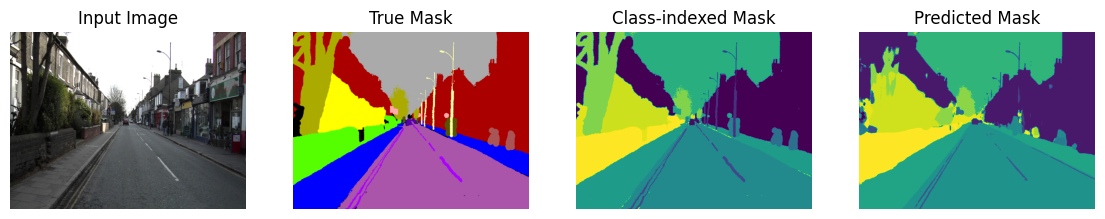

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


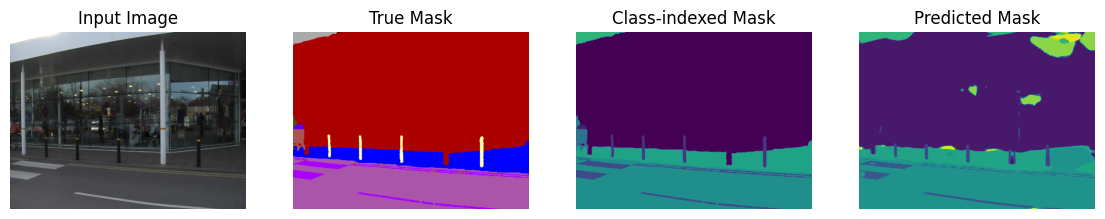

In [57]:
for samples in test_ds.take(10):
    sample_img = (samples[0][0], samples[1][0], model.predict(samples[0])[0])
    display_imgs(sample_img, unique_classes, show_classes=False)

In [58]:
labels_list = []

for x_batch, y_batch in test_ds:    
    labels_list.append(y_batch.numpy())

labels = np.concatenate(labels_list, axis=0)

In [59]:
predictions = model.predict(test_ds)
pred_class = tf.argmax(predictions, axis=-1) 
true_class = tf.squeeze(labels, axis=-1)

pred_class = pred_class.numpy()
true_class = true_class.numpy()

58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step


In [62]:
num_classes = len(unique_classes)
pred_class_flat = pred_class.reshape(-1)
true_class_flat = true_class.reshape(-1)

conf_mat_tf = tf.math.confusion_matrix(true_class_flat, pred_class_flat, num_classes=num_classes)
conf_mat_norm =  conf_mat_tf / tf.reduce_sum(conf_mat_tf, axis=1, keepdims=True)
conf_mat = conf_mat_tf.numpy()

In [63]:
sum_over_rows = np.sum(conf_mat, axis=0)
sum_over_cols = np.sum(conf_mat, axis=1)
diag = np.diag(conf_mat)
denominator = sum_over_rows + sum_over_cols - diag
iou_per_class = diag / (denominator + 1e-7)
mean_iou = np.mean(iou_per_class)

pixel_accuracy = np.sum(diag) / np.sum(conf_mat)

print("IoU per class:", iou_per_class)
print("Mean IoU:", mean_iou)
print("Pixel-wise Accuracy:", pixel_accuracy)

IoU per class: [4.70573609e-05 5.62163735e-05 5.43749401e-03 2.17759726e-04
 4.81929977e-02 1.60680937e-03 3.30994499e-04 2.23556031e-04
 7.99663246e-03 1.62751539e-03 1.14635628e-02 1.70984013e-05
 4.28553431e-03 6.41262004e-05 2.91711230e-03 1.86861510e-03
 6.20584398e-03 1.47164142e-03 2.20773361e-03 1.40830512e-03
 1.02870048e-03 1.60278553e-03 8.57314600e-03 0.00000000e+00
 3.34477783e-03 0.00000000e+00 3.96614690e-02 1.46340430e-03
 0.00000000e+00 1.24713919e-03 2.44298271e-02 5.06790866e-03]
Mean IoU: 0.005752055135504546
Pixel-wise Accuracy: 0.02640710589529454
